In [21]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [7]:
# Here, we define the key parameters for our model and data.
# - LOOKBACK_WINDOW: How many past time steps the model uses to make a prediction.
# - FORECAST_HORIZON: How many future time steps the model will predict.
# - MODEL_DIR: The directory where the trained model and scalers will be saved.
LOOKBACK_WINDOW = 24  # Using the past 24 hours of data
FORECAST_HORIZON = 7  # To predict the next 7 hours/steps
MODEL_DIR = 'models/saved_model'
DATA_FILE = 'weather_data.csv'
EPOCHS = 100

# Create the directory to save the model if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Configuration loaded:")
print(f"  - Lookback Window: {LOOKBACK_WINDOW} steps")
print(f"  - Forecast Horizon: {FORECAST_HORIZON} steps")
print(f"  - Model Save Directory: {MODEL_DIR}")

Configuration loaded:
  - Lookback Window: 24 steps
  - Forecast Horizon: 7 steps
  - Model Save Directory: models/saved_model


In [8]:
try:
    print("Please upload your CSV file now. Click 'Choose Files'.")
    uploaded = files.upload()

    if DATA_FILE not in uploaded:
        print(f"Error: The file '{DATA_FILE}' was not uploaded. Please try again.")
    else:
        df = pd.read_csv(DATA_FILE, parse_dates=['datetime'])
        print("\nDataset loaded successfully from uploaded file.")
        print(f"Dataset shape: {df.shape}")
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
        print("\nDataset Info:")
        df.info()
except Exception as e:
    print(f"Error: Failed to load dataset. {e}")

Please upload your CSV file now. Click 'Choose Files'.


Saving weather_data.csv to weather_data.csv

Dataset loaded successfully from uploaded file.
Dataset shape: (3650, 15)

First 5 rows of the dataset:
             datetime   timestamp   temp  humidity  pressure  rain_analog  \
0 2024-04-24 00:42:00  1713899520  30.65      30.0    1007.6           98   
1 2024-04-24 02:42:00  1713906720  28.65      44.0    1008.3           97   
2 2024-04-24 04:13:00  1713912180  26.65      30.0    1015.5           98   
3 2024-04-24 07:54:00  1713925440  28.65      31.0    1009.2           98   
4 2024-04-24 09:07:00  1713929820  32.65      40.0    1012.4           97   

   rain_detected  light_intensity  nh3     co  co2  alcohol    lpg    ch4  aqi  
0          False             10.0  2.3  127.0  0.5      0.9  256.4  252.1  171  
1          False             14.0  3.3  146.0  0.6      1.0  269.4  272.5  196  
2          False              0.0  2.2  128.0  0.5      0.9  245.2  248.4  169  
3          False            258.0  3.6  154.0  0.7      1.2  264

In [9]:
# We create new features from the 'datetime' column. Time-based features like
# the hour of the day or month of the year can help the model detect cyclical
# weather patterns (e.g., daily temperature cycles).
df['precipitation'] = 1 - (df['rain_analog'] / 1023.0)

df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['day_of_year'] = df['datetime'].dt.dayofyear

# Create cyclical features for time, which help the model understand time's cyclical nature
# (e.g., hour 23 is close to hour 0).
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print("Time-based features created:")
print(df[['datetime', 'hour', 'hour_sin', 'hour_cos', 'month', 'month_sin', 'month_cos']].head())

Time-based features created:
             datetime  hour  hour_sin  hour_cos  month  month_sin  month_cos
0 2024-04-24 00:42:00     0  0.000000  1.000000      4   0.866025       -0.5
1 2024-04-24 02:42:00     2  0.500000  0.866025      4   0.866025       -0.5
2 2024-04-24 04:13:00     4  0.866025  0.500000      4   0.866025       -0.5
3 2024-04-24 07:54:00     7  0.965926 -0.258819      4   0.866025       -0.5
4 2024-04-24 09:07:00     9  0.707107 -0.707107      4   0.866025       -0.5


In [10]:
# We define which columns will be our input features (X) and which we want to
# predict (y). We then scale the data to a range between 0 and 1.
# Normalization is essential for neural networks to train effectively.
FEATURE_COLS = [
    'temp', 'humidity', 'pressure', 'rain_analog',
    'light_intensity', 'aqi', 'precipitation', 'hour', 'day_of_week', 'month', 'day_of_year',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

TARGET_COLS = ['temp', 'precipitation', 'aqi']

df_model = df[FEATURE_COLS].copy()

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(df_model)
scaled_targets = target_scaler.fit_transform(df_model[TARGET_COLS])

print("Data scaling complete.")
print(f"Scaled features shape: {scaled_features.shape}")
print(f"Scaled targets shape: {scaled_targets.shape}")

joblib.dump(feature_scaler, os.path.join(MODEL_DIR, 'feature_scaler.pkl'))
joblib.dump(target_scaler, os.path.join(MODEL_DIR, 'target_scaler.pkl'))
print(f"Scalers saved to '{MODEL_DIR}'")

Data scaling complete.
Scaled features shape: (3650, 15)
Scaled targets shape: (3650, 3)
Scalers saved to 'models/saved_model'


In [11]:
# LSTMs require data to be in a sequence format of [samples, timesteps, features].
# This function converts our flat data into these sequences.
# For each sample, we take `lookback` number of historical steps as input (X)
# and the next `forecast_horizon` steps as the output to predict (y).
def create_sequences(features, targets, lookback, horizon):
    X, y = [], []
    for i in range(len(features) - lookback - horizon + 1):
        X.append(features[i:(i + lookback)])
        y.append(targets[i + lookback:i + lookback + horizon])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_features, scaled_targets, LOOKBACK_WINDOW, FORECAST_HORIZON)

print("Time-series sequences created.")
print(f"Shape of X_seq: {X_seq.shape}")
print(f"Shape of y_seq: {y_seq.shape}")

Time-series sequences created.
Shape of X_seq: (3620, 24, 15)
Shape of y_seq: (3620, 7, 3)


In [12]:
# We split our sequenced data into a training set (for teaching the model) and
# a validation set (for evaluating its performance on unseen data).
# An 80/20 split is a common practice.
split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)

X_train, X_val = X_seq[:split_index], X_seq[split_index:]
y_train, y_val = y_seq[:split_index], y_seq[split_index:]

print("Data split into training and validation sets:")
print(f"  - X_train shape: {X_train.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - X_val shape: {X_val.shape}")
print(f"  - y_val shape: {y_val.shape}")

Data split into training and validation sets:
  - X_train shape: (2896, 24, 15)
  - y_train shape: (2896, 7, 3)
  - X_val shape: (724, 24, 15)
  - y_val shape: (724, 7, 3)


In [13]:
# Here we define the architecture of our neural network.
# - LSTM layers are the core of our model for processing sequences.
# - Dropout layers help prevent overfitting by randomly ignoring some neurons
#   during training.
# - The final Dense layer outputs the prediction.
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = (y_train.shape[1], y_train.shape[2])

model = Sequential([
    LSTM(100, input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(output_shape[0] * output_shape[1]),
    Reshape(output_shape)
])

model.compile(optimizer='adam', loss='mean_squared_error')

print("Model architecture built successfully.")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model architecture built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 100)        │        46,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │         1,071 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,671 (303.40 KB)

 Trainable params: 77,671 (303.40 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# This is where the training happens. The model learns by comparing its
# predictions to the actual target values and adjusting its internal weights.
# - ModelCheckpoint: Saves the best version of the model (with the lowest
#   validation loss) to a file.
# - EarlyStopping: Stops training if the model's performance on the validation
#   set doesn't improve for a certain number of epochs.
model_filepath = os.path.join(MODEL_DIR, 'weather_forecast_model.keras')

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

print("\nModel training complete.")


Starting model training...
Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0653
Epoch 1: val_loss improved from inf to 0.01574, saving model to models/saved_model/weather_forecast_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0651 - val_loss: 0.0157
Epoch 2/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321
Epoch 2: val_loss improved from 0.01574 to 0.01346, saving model to models/saved_model/weather_forecast_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0321 - val_loss: 0.0135
Epoch 3/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0293
Epoch 3: val_loss improved from 0.01346 to 0.01196, saving model to models/saved_model/weather_forecast_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0293 - val_loss: 0.0120
Epoch 4/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265
Epoch 4: val_loss improved from 0.01196 to 0.01119, saving model to models/saved_model/weather_forecast_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 1


Evaluating the model on the validation set...
Validation Loss (MSE): 0.0095
Validation MAE: 0.0604
Validation R-squared (R²): 0.4968

Generating and plotting performance metrics...


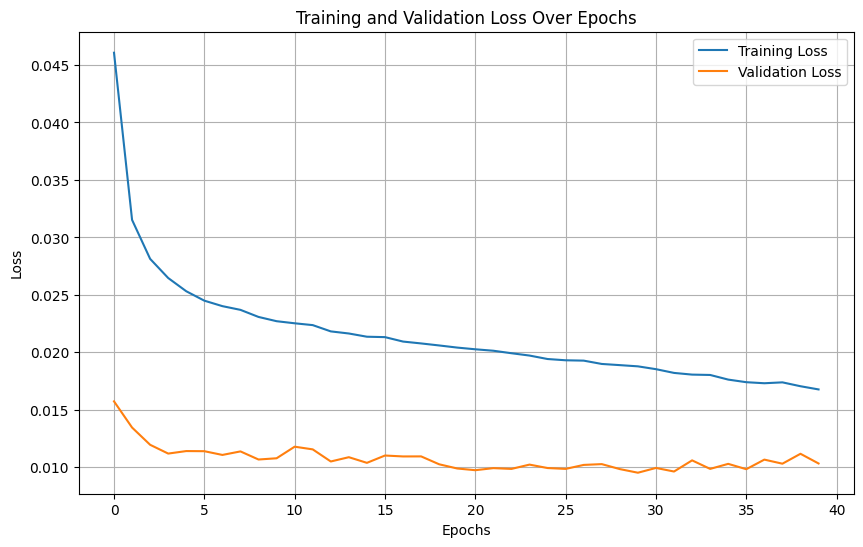

In [22]:
# This section evaluates the model on the validation set and visualizes the training history.
# We also plot the training and validation loss to check for overfitting.
print("\nEvaluating the model on the validation set...")
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss (MSE): {val_loss:.4f}")

# Make predictions on the validation set to calculate additional metrics
val_predictions_scaled = model.predict(X_val, verbose=0)
val_actual_scaled = y_val

# Reshape the data for metric calculation
val_predictions_flat = val_predictions_scaled.reshape(-1, len(TARGET_COLS))
val_actual_flat = val_actual_scaled.reshape(-1, len(TARGET_COLS))

# Calculate MAE and R-squared
mae = mean_absolute_error(val_actual_flat, val_predictions_flat)
r2 = r2_score(val_actual_flat, val_predictions_flat)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation R-squared (R²): {r2:.4f}")

print("\nGenerating and plotting performance metrics...")

train_loss = history.history['loss']
val_loss_history = history.history['val_loss']
epochs_ran = len(train_loss)

plt.figure(figsize=(10, 6))
plt.plot(range(epochs_ran), train_loss, label='Training Loss')
plt.plot(range(epochs_ran), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Here we load the best saved model, make a prediction, and save it to the specified directory.
print("\nLoading the best model saved by ModelCheckpoint...")
saved_model = tf.keras.models.load_model(model_filepath)

# Make a prediction on a sample from the validation set
sample_prediction_scaled = saved_model.predict(X_val[0:1], verbose=0)

# Inverse transform the prediction and the actual value to see the real numbers
sample_prediction_actual = target_scaler.inverse_transform(sample_prediction_scaled.reshape(-1, len(TARGET_COLS)))
sample_ground_truth_actual = target_scaler.inverse_transform(y_val[0].reshape(-1, len(TARGET_COLS)))

print("\n--- Sample Prediction vs. Actual Value ---")
print(f"Prediction for the next {FORECAST_HORIZON} steps:")
pred_df = pd.DataFrame(sample_prediction_actual, columns=TARGET_COLS)
print(pred_df)

print(f"\nActual values for the next {FORECAST_HORIZON} steps:")
actual_df = pd.DataFrame(sample_ground_truth_actual, columns=TARGET_COLS)
print(actual_df)

print(f"\nNotebook execution finished. The model and scalers are saved in the '{MODEL_DIR}' directory.")




Loading the best model saved by ModelCheckpoint...

--- Sample Prediction vs. Actual Value ---
Prediction for the next 7 steps:
        temp  precipitation         aqi
0  13.103620       0.913790  241.063644
1  10.549032       0.909692  227.097137
2   8.748154       0.907007  240.283920
3   9.075470       0.906281  263.536865
4  12.363822       0.907120  250.490631
5  17.512257       0.909731  229.330658
6  21.626682       0.909917  230.292557

Actual values for the next 7 steps:
    temp  precipitation    aqi
0  10.65       0.902248  259.0
1   8.70       0.902248  282.0
2   6.85       0.902248  302.0
3   8.75       0.904203  327.0
4  12.50       0.904203  325.0
5  18.25       0.904203  280.0
6  22.05       0.906158  254.0

Notebook execution finished. The model and scalers are saved in the 'models/saved_model' directory.


In [19]:
from google.colab import files
files.download("models/saved_model/weather_forecast_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>